C:\Users\sinha\AppData\Local\Temp\ipykernel_5848\1279689676.py:62: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Data Point 1: Classical Power = 1.0166 W, QAE Estimation = 0.0000
Data Point 2: Classical Power = 1.7180 W, QAE Estimation = 0.0000
Data Point 3: Classical Power = 2.5754 W, QAE Estimation = 0.0000
Data Point 4: Classical Power = 3.5422 W, QAE Estimation = 0.0000
Data Point 5: Classical Power = 4.6991 W, QAE Estimation = 0.0000
Data Point 6: Classical Power = 6.0193 W, QAE Estimation = 0.0000
Data Point 7: Classical Power = 7.3652 W, QAE Estimation = 0.0000
Data Point 8: Classical Power = 8.8468 W, QAE Estimation = 0.0000
Data Point 9: Classical Power = 10.5185 W, QAE Estimation = 0.0000
Data Point 10: Classical Power = 12.7514 W, QAE Estimation = 0.0000
Data Point 11: Classical Power = 15.3962 W, QAE Estimation = 0.0000
Data Point 12: Classical Power = 19.5322 W, QAE Estimation = 0.0000
Data Point 13: Classical Power = 26.2687 W, QAE Estimation = 0.0000
Data Point 14: Classical Power = 30.8448 W, QAE Estimation = 0.0000
Data Point 15: Classical Power = 36.8950 W, QAE Estimation = 0.00

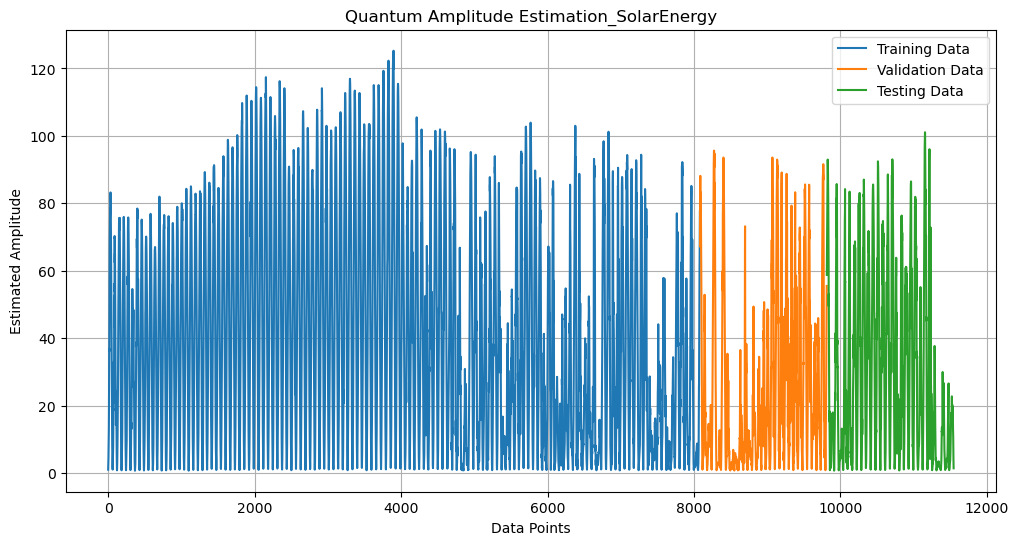

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler  # Adjusted for Qiskit 1.2.1 compatibility
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
import random


# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Constants for power output equation
T_ref = 25  # Reference temperature in Celsius
G_ref = 1000  # Reference irradiance in W/m²
R = 0.700  # Load resistance for the battery pack in ohms
r_s = 18.15  # Internal resistance of two series-connected solar panels
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Load data from CSV
data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv")
T = data['T'].values  # Temperature data
G_theta = data['G_theta'].values  # Irradiance data
V_oc = data['V_oc'].values  # Open-circuit voltage data
I_sc = data['I_sc'].values  # Short-circuit current data

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Improved state preparation to encode power output
def power_to_rotation_angle(power):
    max_power = np.max(powers) if len(powers) > 0 else 1
    return np.arcsin(np.clip(power / max_power, 0, 1))

# Define Quantum Circuit for Amplitude Estimation with Power Encoding
def quantum_amplitude_estimation(power):
    num_qubits = 3  # Number of qubits for the state preparation circuit

    # Create a quantum circuit for amplitude estimation (state preparation)
    qae_circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard to the first two qubits
    for qubit in range(num_qubits - 1):
        qae_circuit.h(qubit)

    # Encode power into a rotation on the last qubit
    angle = power_to_rotation_angle(power)
    qae_circuit.ry(2 * angle, num_qubits - 1)

    # Add measurement to the last qubit
    qae_circuit.measure_all()

    # Use Sampler to execute the circuit
    sampler = Sampler()
    result = sampler.run([qae_circuit]).result()
    counts = result.quasi_dists[0]
    estimated_value = counts.get(1, 0) / sum(counts.values())  # Estimate probability of the last qubit being 1

    return estimated_value

# Variables to track optimum values
optimum_power = -np.inf
optimum_index = -1

# Iterate over the data points and maximize the objective function P
powers = []
for i in range(len(T)):
    # Classical calculation of power
    P_classical = power_output(V_oc[i], T[i], I_sc[i], G_theta[i])
    powers.append(P_classical)

    # Run Quantum Amplitude Estimation (QAE)
    qae_value = quantum_amplitude_estimation(P_classical)

    #print(f"Data Point {i+1}: Classical Power = {P_classical:.4f} W, QAE Estimation = {qae_value:.4f}")

    # Track the optimum value
    if P_classical > optimum_power:
        optimum_power = P_classical
        optimum_index = i

# Display the data point corresponding to the optimum value
#print(f"\nOptimum power is {optimum_power:.4f} W achieved at data point {optimum_index+1}:")
print(f"T = {T[optimum_index]:.4f}, G_theta = {G_theta[optimum_index]:.4f}, V_oc = {V_oc[optimum_index]:.4f}, I_sc = {I_sc[optimum_index]:.4f}")

# Split data into training, validation, and testing sets
train_size = int(0.7 * len(powers))
val_size = int(0.15 * len(powers))

train_powers = powers[:train_size]
val_powers = powers[train_size:train_size + val_size]
test_powers = powers[train_size + val_size:]

# Visualize and save the output
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_powers)), train_powers, label='Training Data')
plt.plot(range(len(train_powers), len(train_powers) + len(val_powers)), val_powers, label='Validation Data')
plt.plot(range(len(train_powers) + len(val_powers), len(powers)), test_powers, label='Testing Data')
plt.title('Quantum Amplitude Estimation_SolarEnergy')
plt.xlabel('Data Points')
plt.ylabel('Estimated Amplitude')
plt.legend()
plt.grid(True)

# Save the graph as .svg
plt.savefig('qae_power_output_solar_final.svg', dpi=300)
plt.show()